# Skip Reindexing and Reuse Saved Embeddings


In this notebook, we will skip the embedding generation and re-indexing process by loading previously saved document embeddings and metadata from a JSON file. We will then use this data to directly query Elasticsearch and the RetrievalQA chain.
    

In [1]:
import json
import numpy as np
from elasticsearch import Elasticsearch
from langchain.llms import OpenAI
from langchain.chains import RetrievalQA
from langchain.schema import Document
from dotenv import load_dotenv
from langchain.embeddings import OpenAIEmbeddings
import os


# Load the saved embeddings and metadata
with open('document_embeddings.json', 'r') as f:
    saved_data = json.load(f)

# Extract texts, embeddings, and metadata
texts = [item['text'] for item in saved_data]
embeddings = [np.array(item['embedding']) for item in saved_data]
metadatas = [item['metadata'] for item in saved_data]

print("Loaded embeddings and metadata from JSON.")
    

Loaded embeddings and metadata from JSON.


In [2]:

# Initialize Elasticsearch connection
es = Elasticsearch([{'host': 'localhost', 'port': 9200, 'scheme': 'http'}])
index_name = 'fcra_chunks'

# Check if the index already exists
if es.indices.exists(index=index_name):
    print(f"Index '{index_name}' already exists in Elasticsearch. No re-indexing required.")
else:
    print(f"Index '{index_name}' does not exist. Re-indexing is required.")
    index_name = 'fcra_chunks'

    # Delete the index if it already exists (optional)
    if es.indices.exists(index=index_name):
        es.indices.delete(index=index_name)

    # Define the mapping
    mapping = {
        "mappings": {
            "properties": {
                "embedding": {
                    "type": "dense_vector",
                    "dims": 1536
                },
                "text": {
                    "type": "text"
                },
                "metadata": {
                    "type": "object",
                    "enabled": True
                }
            }
        }
    }

    # Create the index with the mapping
    es.indices.create(index=index_name, body=mapping)


Index 'fcra_chunks' already exists in Elasticsearch. No re-indexing required.


In [3]:
#  Load environment variables
load_dotenv()

# Initialize the embedding model with the API key
embedding_model = OpenAIEmbeddings(openai_api_key=os.getenv("OPENAI_API_KEY"))

/var/folders/bs/rk6rcnf923l4k8xms3k927hr0000gn/T/ipykernel_5030/3451141637.py:5: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embedding_model = OpenAIEmbeddings(openai_api_key=os.getenv("OPENAI_API_KEY"))


In [4]:
# Initialize the LLM (GPT)
llm = OpenAI(openai_api_key=os.getenv("OPENAI_API_KEY"))

# Create a Custom Retriever Using Elasticsearch

from langchain.schema import Document
from langchain.schema import BaseRetriever
from typing import Any, List
import numpy as np
from pydantic import BaseModel

class ElasticSearchRetriever(BaseRetriever, BaseModel):
    es: Any
    index_name: str
    embedding_model: Any
    k: int = 5

    class Config:
        arbitrary_types_allowed = True

    def get_relevant_documents(self, query: str) -> List[Document]:
        # Generate and normalize the query embedding
        query_embedding = self.embedding_model.embed_query(query)
        query_embedding = query_embedding / np.linalg.norm(query_embedding)

        # Build the script score query
        script_query = {
            "size": self.k,
            "query": {
                "script_score": {
                    "query": {"match_all": {}},
                    "script": {
                        "source": "cosineSimilarity(params.query_vector, 'embedding') + 1.0",
                        "params": {
                            "query_vector": query_embedding.tolist()
                        }
                    }
                }
            },
            "_source": ["text", "metadata"]
        }

        # Execute the search
        response = self.es.search(index=self.index_name, body=script_query)

        # Convert hits to Documents
        docs = []
        for hit in response['hits']['hits']:
            doc = Document(
                page_content=hit['_source']['text'],
                metadata=hit['_source']['metadata']
            )
            docs.append(doc)
        return docs

# Initialize the Retriever
retriever = ElasticSearchRetriever(
    es=es,
    index_name=index_name,
    embedding_model=embedding_model,
    k=5  # Number of documents to retrieve
)

/var/folders/bs/rk6rcnf923l4k8xms3k927hr0000gn/T/ipykernel_5030/330155363.py:2: LangChainDeprecationWarning: The class `OpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAI``.
  llm = OpenAI(openai_api_key=os.getenv("OPENAI_API_KEY"))
/var/folders/bs/rk6rcnf923l4k8xms3k927hr0000gn/T/ipykernel_5030/330155363.py:12: DeprecationWarning: Retrievers must implement abstract `_get_relevant_documents` method instead of `get_relevant_documents`
  class ElasticSearchRetriever(BaseRetriever, BaseModel):


In [5]:
# Create the RetrievalQA chain using the from_chain_type method
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate

# Define a custom prompt template that encourages the model to use only the retrieved documents
prompt_template = """
You are a helpful assistant that answers questions based only on the following documents:

{context}

If the answer is not in the documents, respond with "I don't know based on the information provided."
Question: {question}
"""

# Create a prompt object using the custom prompt template
prompt = PromptTemplate(template=prompt_template, input_variables=["context", "question"])


qa_chain = RetrievalQA.from_chain_type(
    llm=llm, 
    chain_type="stuff",
    retriever=retriever,
    chain_type_kwargs={"prompt": prompt}
)

In [9]:
# Run a test query
query = "What is prescreening under the FCRA Law, and what does it allow companies to do?"
# query = "What is the capital city of France?"

answer = qa_chain.run(query)
print("Answer:", answer)
    

Answer: 
Answer: Prescreening under the FCRA Law refers to the practice of obtaining a "prescreened" list of consumers in order to make "firm offers" of credit or insurance. This allows companies to target specific consumers with offers based on their credit information without obtaining a consumer report for marketing purposes.


In [8]:
queries = [
    "What are the permissible purposes for obtaining a consumer report?",
    "Explain the dispute process under the FCRA. Which module did you used to answer this question?",
    "What obligations do credit reporting agencies have according to the FCRA? Which module did you used to answer this question?"
]

for query in queries:
    answer = qa_chain.run(query)
    print(f"Query: {query}")
    print(f"Answer: {answer}")
    print("------")

Query: What are the permissible purposes for obtaining a consumer report?
Answer: 
Answer: The permissible purposes for obtaining a consumer report include determining eligibility for credit, insurance, government benefits, renting an apartment, opening a bank account, or cashing a check. Additionally, there is a catch-all phrase for "legitimate business need for the information," but this only applies if the consumer initiates the transaction or has an existing account. If the purpose is not listed as a permissible purpose, it is not allowed under the FCRA.
------
Query: Explain the dispute process under the FCRA. Which module did you used to answer this question?
Answer: 
The dispute process under the FCRA is explained in Module 12: Investigative Consumer Reports. According to this module, consumers have the right to dispute any inaccurate information in their consumer report by contacting the consumer reporting agency and providing any necessary supporting documents. The agency must

In [11]:
import json
from sentence_transformers import SentenceTransformer, util

/Users/hani/Library/Caches/pypoetry/virtualenvs/llm-zoomcamp-project-qjMeP1Bu-py3.11/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


## Evaluation

In [15]:
# Load the ground truth data
ground_truth_file = '../data/Ground Truth/ground_truth.json'
with open(ground_truth_file, 'r') as f:
    ground_truth_data = json.load(f)

In [16]:
import re

def parse_questions_and_answers(qna_text):
    """
    Parses the questions and answers from the provided text.
    Returns a list of dictionaries with 'question' and 'answer' keys.
    """
    qa_list = []
    # Split the text into individual questions and answers
    qa_entries = re.split(r'\n\n+', qna_text.strip())
    for entry in qa_entries:
        # Match the question and answer using regex
        question_match = re.search(r'Question:\s*(.*)', entry)
        answer_match = re.search(r'Answer:\s*(.*)', entry)
        if question_match and answer_match:
            question = question_match.group(1).strip()
            answer = answer_match.group(1).strip()
            qa_list.append({'question': question, 'ground_truth_answer': answer})
    return qa_list


In [17]:
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation (except for necessary ones like periods in abbreviations)
    text = re.sub(r'[^\w\s]', '', text)
    # Strip extra whitespace
    text = text.strip()
    return text


In [18]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [19]:
cosine_similarities = []

for module_name, module_content in ground_truth_data.items():
    qna_text = module_content.get('questions_and_answers', '')
    # Parse the questions and answers
    qa_list = parse_questions_and_answers(qna_text)
    
    for qa in qa_list:
        question = qa['question']
        ground_truth_answer = qa['ground_truth_answer']
        
        # Get the RAG answer
        rag_answer = qa_chain.run(question)
        
        # Preprocess the answers
        ground_truth_answer_pp = preprocess_text(ground_truth_answer)
        rag_answer_pp = preprocess_text(rag_answer)
        
        # Handle cases where RAG answer indicates no information
        if rag_answer_pp in ["I don't know based on the information provided.", ""]:
            cosine_score = 0.0
        else:
            # Compute embeddings
            gt_embedding = model.encode(ground_truth_answer_pp, convert_to_tensor=True)
            rag_embedding = model.encode(rag_answer_pp, convert_to_tensor=True)
            
            # Compute cosine similarity
            cosine_score = util.pytorch_cos_sim(gt_embedding, rag_embedding).item()
        
        # Store the result
        cosine_similarities.append({
            'module': module_name,
            'question': question,
            'ground_truth_answer': ground_truth_answer,
            'rag_answer': rag_answer,
            'cosine_similarity': cosine_score
        })
        
        # Optional: Print the result for each question
        print(f"Module: {module_name}")
        print(f"Question: {question}")
        print(f"Cosine Similarity: {cosine_score:.4f}\n")


Module: Module 01.txt
Question: What was the main purpose of implementing the Fair Credit Reporting Act (FCRA)?
Cosine Similarity: 0.7732

Module: Module 01.txt
Question: What rights does the FCRA provide to consumers regarding their data held by consumer reporting agencies?
Cosine Similarity: 0.8943

Module: Module 01.txt
Question: What obligations does the FCRA impose on companies taking adverse actions based on consumer reports?
Cosine Similarity: 0.8929

Module: Module 02.txt
Question: What is the main focus of Module 2 in regards to consumer reports?
Cosine Similarity: 0.7659

Module: Module 02.txt
Question: What obligations does the Gramm-Leach-Bliley Act impose on financial institutions regarding customer information?
Cosine Similarity: 0.6848

Module: Module 02.txt
Question: How does the Gramm-Leach-Bliley Act address exceptions for disclosing customer information to third parties?
Cosine Similarity: 0.6233

Module: Module 04.txt
Question: What is prescreening under the FCRA La

In [24]:
# Calculate average cosine similarity
average_cosine_similarity = sum([entry['cosine_similarity'] for entry in cosine_similarities]) / len(cosine_similarities)

print(f"Average Cosine Similarity: {average_cosine_similarity:.4f}")

# Save the results to a CSV file
import csv

with open('cosine_similarity_results.csv', 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['module', 'question', 'ground_truth_answer', 'rag_answer', 'cosine_similarity']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for entry in cosine_similarities:
        writer.writerow(entry)

Average Cosine Similarity: 0.7960


In [30]:
# Define a threshold for considering an answer correct
cosine_threshold = 0.8

# Initialize counts
correct_predictions = 0
total_predictions = len(cosine_similarities)

for entry in cosine_similarities:
    cosine_score = entry['cosine_similarity']
    if cosine_score >= cosine_threshold:
        correct_predictions += 1

# Calculate accuracy
accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0

print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.5000


In [33]:
thresholds = [i / 100 for i in range(50, 100, 5)]  # Thresholds from 0.50 to 0.95 in steps of 0.05

import matplotlib.pyplot as plt

# Assuming 'cosine_similarities' is a list of dictionaries from previous computations
# Each entry has 'cosine_similarity' key

thresholds = [i / 100 for i in range(50, 100, 5)]  # Thresholds from 0.50 to 0.95
accuracies = []

total_predictions = len(cosine_similarities)

for threshold in thresholds:
    correct_predictions = sum(1 for entry in cosine_similarities if entry['cosine_similarity'] >= threshold)
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    accuracies.append(accuracy)
    print(f"Threshold: {threshold:.2f}, Accuracy: {accuracy:.4f}")



Threshold: 0.50, Accuracy: 1.0000
Threshold: 0.55, Accuracy: 1.0000
Threshold: 0.60, Accuracy: 0.9583
Threshold: 0.65, Accuracy: 0.8750
Threshold: 0.70, Accuracy: 0.8333
Threshold: 0.75, Accuracy: 0.7083
Threshold: 0.80, Accuracy: 0.5000
Threshold: 0.85, Accuracy: 0.3333
Threshold: 0.90, Accuracy: 0.1250
Threshold: 0.95, Accuracy: 0.0000


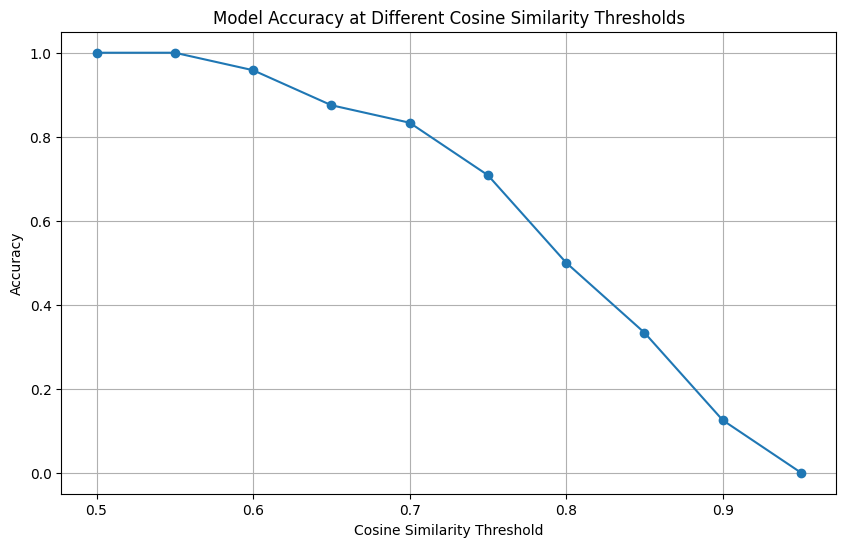

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracies, marker='o')
plt.title('Model Accuracy at Different Cosine Similarity Thresholds')
plt.xlabel('Cosine Similarity Threshold')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()